<a href="https://colab.research.google.com/github/hero-hub/cnn_psf/blob/main/cnn_resnet_2layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import zipfile
from google.colab import drive
import sys

# Загрузка и подготовка данных


In [2]:
# Подключение Google Drive
drive.mount('/content/drive')

# Путь к папке, где находится library_help_tools.py
sys.path.insert(0, '/content/drive/My Drive/Colab_Notebooks/scripts')

print(sys.path)

try:
    import library_help_tools as lht
    print("Модуль успешно импортирован!")
except ModuleNotFoundError as e:
    print(f"Ошибка импорта: {e}")

# Максимальная абсолютная ошибка
def max_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Приводим y_true к float32
    y_pred = tf.cast(y_pred, tf.float32)  # Приводим y_pred к float32
    return tf.reduce_max(tf.abs(y_true - y_pred))

Mounted at /content/drive
['/content/drive/My Drive/Colab_Notebooks/scripts', '/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython']
Модуль успешно импортирован!


In [3]:
zip_file = '/content/drive/My Drive/Colab_Notebooks/img256_7987.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

def load_images_from_directory(dir_read):
    images = []  # Список для хранения изображений
    list_file = os.listdir(dir_read)  # Получаем список файлов в директории

    for cur_file in list_file:
        cur_file_path = os.path.join(dir_read, cur_file)
        try:
            img = Image.open(cur_file_path)
            images.append(img)
        except Exception as e:
            print(f"Ошибка при чтении файла {cur_file_path}: {e}")

    print(f'Количество загруженных изображений - {len(images)}')
    return images

zip_directory = 'img256_7987/img256_7987/'
images = load_images_from_directory(zip_directory)

['.config', 'img256_7987', 'drive', 'sample_data']
Количество загруженных изображений - 7987


In [4]:
# Создаем словарь с параметрами
GVD = dict(
    DATA_DIR = zip_directory,
    FILE_FORMAT = ".png",
    IMG_SIZE = 256,
    TEST_SPLIT = 0.2,
    VALIDATION_SPLIT = 0.2,
    SEED = 123
)

In [5]:
# Загрузка данных
ts_images, ts_labels = lht.load_data(lht.list_files(GVD['DATA_DIR'], GVD['FILE_FORMAT']))

# Преобразование в numpy массивы, если это еще не сделано
ts_images = np.array(ts_images)
ts_labels = np.array(ts_labels)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    ts_images, ts_labels, test_size=0.2, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Преобразование в tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(32)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Создание модели

In [6]:
# Входной слой
inputs = layers.Input(shape=(256, 256, 1))  #256x256 и ЧБ (1 канал)

# Предварительные сверточные слои
x = layers.Conv2D(64, 3, activation='gelu', padding='same')(inputs)
x = layers.Conv2D(128, 5, activation='gelu', padding='same')(x)

# ResNet50
resnet = ResNet50(
    include_top=False,
    weights=None,
    input_tensor=x,  # Передаем выход предыдущего слоя
    pooling='avg'  # Глобальное усреднение
)

# Выходной слой
outputs = layers.Dense(2, activation='linear')(resnet.output)

# Создание модели
model = models.Model(inputs=inputs, outputs=outputs)

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        max_error
    ]
)

# Обучение модели

In [7]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=16,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_rmse')
    ]
)

Epoch 1/16
160/160 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - loss: 3615.4746 - max_error: 59.5562 - rmse: 55.3620 - val_loss: 880.2437 - val_max_error: 52.4842 - val_rmse: 29.6689
Epoch 2/16
160/160 ━━━━━━━━━━━━━━━━━━━━ 146s 911ms/step - loss: 7.2312 - max_error: 5.2562 - rmse: 2.6826 - val_loss: 1031.6604 - val_max_error: 59.1798 - val_rmse: 32.1195
Epoch 3/16
160/160 ━━━━━━━━━━━━━━━━━━━━ 146s 912ms/step - loss: 5.2934 - max_error: 4.1823 - rmse: 2.2957 - val_loss: 173.5740 - val_max_error: 20.1078 - val_rmse: 13.1747
Epoch 4/16
160/160 ━━━━━━━━━━━━━━━━━━━━ 145s 909ms/step - loss: 3.5186 - max_error: 3.3528 - rmse: 1.8720 - val_loss: 51.5606 - val_max_error: 10.0114 - val_rmse: 7.1806
Epoch 5/16
160/160 ━━━━━━━━━━━━━━━━━━━━ 145s 909ms/step - loss: 4.1326 - max_error: 3.5454 - rmse: 2.0294 - val_loss: 18.4603 - val_max_error: 5.9173 - val_rmse: 4.2965
Epoch 6/16
160/160 ━━━━━━━━━━━━━━━━━━━━ 145s 909ms/step - loss: 3.4134 - max_error: 3.0545 - rmse: 1.8356 - val_loss: 22.0092 - val_max_error:

# Оценка и визуализация


Ошибки на тестовом наборе:
RMSE: 1.43 пикселей
Максимальная ошибка: 2.73 пикселей


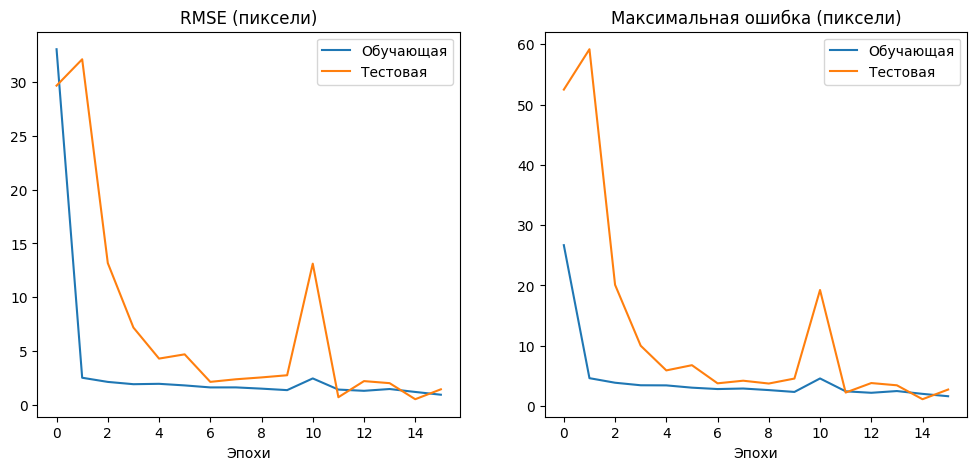

In [8]:
# Оценка на тестовом наборе
test_loss, test_rmse, test_max_error = model.evaluate(test_ds, verbose=0)
print(f"\nОшибки на тестовом наборе:")
print(f"RMSE: {test_rmse:.2f} пикселей")
print(f"Максимальная ошибка: {test_max_error:.2f} пикселей")

# Визуализация обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['rmse'], label='Обучающая')
plt.plot(history.history['val_rmse'], label='Тестовая')
plt.title('RMSE (пиксели)')
plt.xlabel('Эпохи')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['max_error'], label='Обучающая')
plt.plot(history.history['val_max_error'], label='Тестовая')
plt.title('Максимальная ошибка (пиксели)')
plt.xlabel('Эпохи')
plt.legend()
plt.show()

# Предсказание на случайном изображении из датасета

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


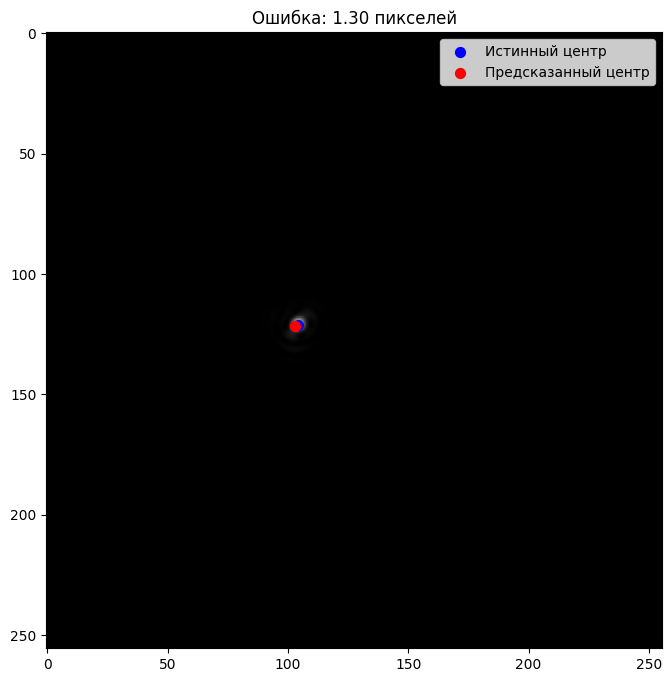

In [9]:
import random

# Тестовый датасет в виде списка
test_images = list(test_ds.unbatch().as_numpy_iterator())

# Выбираем случайное изображение
random_sample = random.choice(test_images)
sample_image = random_sample[0][np.newaxis, ...]  # Добавляем batch-размерность
true_center = random_sample[1][np.newaxis, ...]  # Добавляем batch-размерность

# Получаем предсказание
predicted_center = model.predict(sample_image)[0]

# Отображение результата
plt.figure(figsize=(8, 8))
plt.imshow(sample_image[0].squeeze(), cmap='gray')
plt.scatter(true_center[0][1], true_center[0][0], c='blue', s=50, label='Истинный центр')
plt.scatter(predicted_center[1], predicted_center[0], c='red', s=50, label='Предсказанный центр')
plt.title(f"Ошибка: {np.linalg.norm(true_center[0] - predicted_center):.2f} пикселей")
plt.legend()
plt.show()

# Сохранение модели

In [ ]:
#model_path = '/content/drive/My Drive/Colab_Notebooks/psf_center_model.h5'
#model.save(model_path)

# Сохранение истории обучения
#import pickle
#history_path = '/content/drive/My Drive/Colab_Notebooks/history.pkl'
#with open(history_path, 'wb') as f:
#    pickle.dump(history.history, f)